In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit import Aer, IBMQ, assemble, execute, BasicAer, ClassicalRegister, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.circuit import Gate, Parameter
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library.standard_gates import RYGate

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

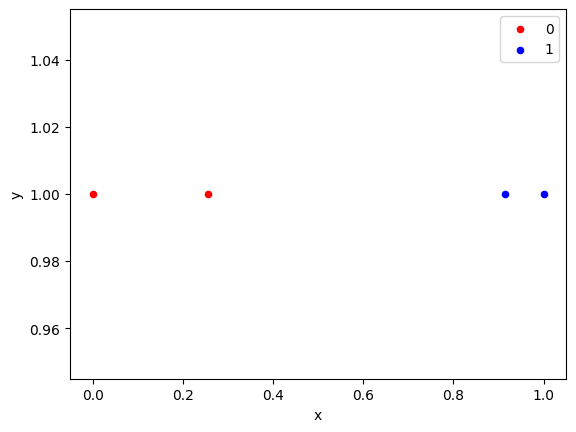

In [2]:
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
from pandas import DataFrame
from math import log2, ceil, pi
import numpy as np
from sklearn import preprocessing



e0 = 0.001
N_size = 4
encoding_bits = int(ceil(log2(N_size)))
rescale_factor = 1


minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, rescale_factor))


# X_temp,y_circ = make_circles(n_samples=256, noise=0.025, random_state=5465)
# X_circ = minmax_scale.fit_transform(X_temp) # scale the data from 0-100


# df = DataFrame(dict(x=X_circ[:,0], y=X_circ[:,1], label=y_circ))
# colors = {0:'red', 1:'blue'}
# fig, ax = plt.subplots()
# grouped = df.groupby('label')
# for key, group in grouped:
#     group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
# plt.show()

X_temp,y_blobs = make_blobs(n_samples=N_size, n_features=1, random_state=4343, centers=2)
X_blobs = minmax_scale.fit_transform(X_temp) # scale the data from 0-100

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X_blobs[:,0], y=1, label=y_blobs))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [3]:
print(X_blobs)

[[0.        ]
 [0.91412391]
 [1.        ]
 [0.25513021]]


In [4]:
vertex = range(X_blobs.shape[0])
print(vertex)
# step 1: build verteces and edges to make graph: G = (V,E)
# step 2: build the W matrix which is symmetric using RBF_kernel and remove the 1's across the diagonal
# step 3: buld D which the sum across axis=1 
# step 4: build laplacian, L = D-W
# step 5: normalize laplacian, L_s = D^(-1/2)*L*D^(-1/2)


range(0, 4)


In [163]:
# set up the initial space
# n = log2(N), where N is dataset size
# t = n + round up(2 + log2(1/2*e0) where e0 is the error rate of phase estimation, we will choose e0 = 0.001
zero_state = np.array([1,0])
one_state = np.array([0,1])
single_dim_identity = np.eye(2)
zero_single_dim_projector = np.outer(zero_state,np.transpose(zero_state))
one_single_dim_projector = np.outer(one_state,np.transpose(one_state))

identity_power = lambda k: kronecker_power(single_dim_identity,k)

def unitary_initilization(qc,t,n):
    """
    This puts both lower 'n' registers entangled with each other
    """
    # entangle the states
    for i in range(n):
        qc.h(t+i)
        qc.cx(t+i,t+n+i)
    return qc

def kronecker_power(matrix, k):
    import numpy as np
    new_matrix = matrix.copy()
    for _ in range(k-1):
        new_matrix = np.kron(new_matrix,matrix)
    return new_matrix

def get_specific_operator_for_iteration(counting_qubit, unitary_l_norm_op, t, n):
    """
    Apply specific operator for given iteration within quantum phase estimation algorithm.
    """
    zero_control = None
    one_control = None

    if counting_qubit == 0:
        # (zero_single_dim_projector) * (Identity ^* (t+n-counting_qubit-1))
        zero_control = np.kron(zero_single_dim_projector,identity_power(t+n-counting_qubit-1))
        # (one_single_dim_projector) * (Identity ^* (t-counting_qubit-1)) * Unitary_to_apply
        one_control = np.kron(np.kron(one_single_dim_projector,identity_power(t-counting_qubit-1)), unitary_l_norm_op)
    else:
        common_iden = identity_power(counting_qubit)
        # (Identity ^* counting_qubit) * (zero_single_dim_projector) * (Identity ^* (t+n-counting_qubit-1))
        zero_control = np.kron(np.kron(common_iden,zero_single_dim_projector),identity_power(t+n-counting_qubit-1))
        if counting_qubit == t-1:
            # (Identity ^* counting_qubit) * (one_single_dim_projector) * Unitary_to_apply
            one_control = np.kron(np.kron(common_iden,one_single_dim_projector), unitary_l_norm_op)
        else:
            # (Identity ^* counting_qubit) * (one_single_dim_projector) * (Identity ^* (t-counting_qubit-1)) * Unitary_to_apply
            one_control = np.kron(np.kron(np.kron(common_iden,one_single_dim_projector),identity_power(t-counting_qubit-1)), unitary_l_norm_op)
    
    assert zero_control.shape == one_control.shape
    
    return zero_control + one_control

def qsc_multi_qubit_unitary_phase_estimation(qc,l_norm,t,n):
    from matrix_exp import get_exponential_unitary
    from qiskit.circuit.library import QFT
    """
    Recieves normalized laplacian and outputs phase estimation algorithm
    """
    for i in range(t):
        qc.h(i)
    
    #Build the giant control unitary
    unitary_l_norm_op = get_exponential_unitary(l_norm)    


    active_qubits = [i for i in range(t+n)]

    repetitions = 1
    for counting_qubit in range(t):
        
        # get the corresponding CNOT operation for the given iteration
        unitary_control_op = get_specific_operator_for_iteration(counting_qubit,unitary_l_norm_op,t,n)

        for i in range(repetitions):
            # apply the control-U
            qc.unitary(unitary_control_op, qubits=active_qubits)
        repetitions *= 2
    
    estimation_qubits = [i for i in range(t)]
    qc = qc.compose(QFT(num_qubits=t, inverse=True), estimation_qubits)
    # # Measure of course!
    # for c in estimation_qubits:
    #     qc.measure(c,c)
    
    return qc


def bottom_up_quantum_phase_estimation(qc, estimation_qubits=[], qubit_to_estimate=0):
    from qiskit.circuit.library import QFT
    import math
    if len(estimation_qubits)==0:
        estimation_qubits = [i+1 for i in range(qc.num_qubits-1)] # just the last couple
    # Apply H-Gates to counting qubits:
    for qubit in estimation_qubits:
        qc.h(qubit)
    print(f"inside function qc.num_clbits:{qc.num_clbits}")
    # Prepare our eigenstate |psi>:
    qc.x(qubit_to_estimate)

    # Do the controlled-U operations:
    angle = 2*math.pi/3
    repetitions = 1
    for counting_qubit in estimation_qubits[::-1]: # reverse
        for _ in range(repetitions):
            qc.cp(angle, counting_qubit, qubit_to_estimate);
        repetitions *= 2

    # Do the inverse QFT:
    qc = qc.compose(QFT(num_qubits=len(estimation_qubits), inverse=True), estimation_qubits)
    # Measure of course!
    for c in estimation_qubits:
        qc.measure(c,c)

    return qc

def NormalizedLaplaceTransform(W):
    # print(f"W orginial: {W}")
    diag_elements = np.diag(np.diag(W))
    W = W-diag_elements
    # print(f"W with diagonals as zero:{W}")
    diagment = np.sum(W,axis=1)
    D=np.diag(diagment)
    # print(f"D:{D}")
    L = D-W
    # print(f"L:{L}")
    D_sqrt = np.sqrt(np.linalg.inv(D))
    # print(f"D_sqrt:{D_sqrt}")
    l_norm = np.matmul(D_sqrt,np.matmul(L,D_sqrt))
    # print(f"l_norm:{l_norm}")
    return l_norm

def get_adjacency_and_weight_matrix(raw_data, n_nearest_neighbors):
    n = len(raw_data)
    
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=n_nearest_neighbors, algorithm='auto').fit(raw_data)
    distances, indices = nbrs.kneighbors(raw_data)

    from sklearn.metrics.pairwise import rbf_kernel
    rbf = rbf_kernel(raw_data) # input must be np.array

    # only add weights if indices correspond to a connection
    weight_matrix = np.zeros((n,n))
    for i in range(len(indices)):
        for j in indices[i]:
            weight_matrix[i,j] = rbf[i][j]
    
    adjacency = nbrs.kneighbors_graph(raw_data).toarray()
    return adjacency, weight_matrix

def get_binary_number(x,n):
    return format(x, 'b').zfill(n)

##########################################################################################
##########################################################################################

# def quantum_circuit(circuit, qubits, image_array, row):
#     ###### NNNEEEEEDDDD TOOOOO FIXXXXXX THIISSSSSSS ###############
#     # changed: encoding_bits,
#     circuit.h(np.arange(qubits-1))

#     for col in range(image_array.shape[0]):
#         control_state = get_binary_number(col,encoding_bits)

#         RYj = Operator(RYGate(pi/N_size*image_array[col]).control(encoding_bits, label = 'Pixel '+str(col), ctrl_state=control_state))
#         RYi = Operator(RYGate(-pi/N_size*image_array[row]).control(encoding_bits, label = 'Pixel '+str(row), ctrl_state=control_state))

#         circuit.append(RYi.compose(RYj), range(qubits))
#     circuit.measure(range(qubits), range(qubits))
#     return circuit


# def measure_circuit(qde, backend, n_shots):
#     job = backend.run(transpile(qde, backend), shots=n_shots)
#     counts = job.result().get_counts()
#     return counts


# def retrieve_matrix_from_measurements(qubits, counts):
#     measurements = np.array([0 for i in range(len(counts))])
#     states_list = [0 for i in range(len(counts))]
#     measurements, states_list = obtain_measurements_and_states_from_counts(counts, measurements, states_list)
#     prob_array = obtain_probability_array(measurements, states_list, qubits)
#     retrieved_image = np.arccos(np.sqrt(prob_array))*512/pi
#     return retrieved_image


# def obtain_measurements_and_states_from_counts(counts, measure_array, states_array):
#     num = 0
#     for bitstring, measure in counts.items():
#         measure_array[num] = measure
#         states_array[num] = int(bitstring,2)
#         num += 1
#     return measure_array, states_array


# def obtain_probability_array(measure_array, states_array, qubits):
#     index = np.argsort(states_array)
#     measure_array = measure_array[index]
#     prob_array = measure_array*(1/measure_array.sum())
#     prob_array = check_numbers((2**(qubits-1))*prob_array[:2**(qubits-1)])
#     return prob_array


# def compute_edges(matrix):
#     edges = [] # Initialize the list
#     for i in range(matrix.shape[0]):
#         for j in range(matrix.shape[1]): # for every column and row, do
#             if matrix[i][j]!=0 and i!=j: # Except when the values of the adj matrix are 0
#                 edges.append((i, j)) # Append the value of the column and row
#     return edges


##########################################################################################
##########################################################################################

def compute_laplacian(data, data_size, k_clusters):
    # initialize circuit
    n = ceil(log2(data_size))
    t = n + int(ceil(2 + log2(1/(2*e0))))
    user_selected_d = n
    
    # print(t+n+n)
    # must be t+n+n qubits
    num_bits = t+n+n
    qsc_circ = QuantumCircuit(num_bits,num_bits)
    
    adjacency, weight_matrix = get_adjacency_and_weight_matrix(data, user_selected_d)

    normalized_laplacian = NormalizedLaplaceTransform(weight_matrix)/(2*user_selected_d) # just to get eigenvalues from [0,1], doesn't change eigenvectors

    print(f"normalized_laplacian:{normalized_laplacian}")

    # print(laplacian)
    from numpy.linalg import eig
    # print("verify laplacian has eigenvalues 0 <= lambda")
    
    print(f"eig(laplacian):{eig(normalized_laplacian)}")

    return normalized_laplacian


In [162]:
kronecker_power(np.eye(2),1)

array([[1., 0.],
       [0., 1.]])

In [6]:
N = len(X_blobs)
n = ceil(log2(N))
user_selected_d = n
normalized_laplacian = compute_laplacian(X_blobs, N, k_clusters=2)

normalized_laplacian:[[ 0.25  0.    0.   -0.25]
 [ 0.    0.25 -0.25  0.  ]
 [ 0.   -0.25  0.25  0.  ]
 [-0.25  0.    0.    0.25]]
eig(laplacian):(array([0.5, 0. , 0.5, 0. ]), array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.70710678,  0.70710678],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678],
       [-0.70710678,  0.70710678,  0.        ,  0.        ]]))


In [7]:
"""
Get d smallest eigenvalues
"""
import scipy.sparse.linalg as sla
eigenvalues, eigenvectors = sla.eigs(normalized_laplacian, user_selected_d, which='SM') 
# print(eigenvectors)


In [28]:
from fable import fable_with_existing_circuit,fable
"""
epsilon: float >= 0 (compression threshold)
alpha: subnormalization factor
"""

import math
qpe_estimation_qubits = 6
logn = int(math.ceil(math.log2(len(normalized_laplacian))))
fable_qubits = 2*logn + 1
n_bits = fable_qubits + qpe_estimation_qubits
q_circ = QuantumCircuit(n_bits, n_bits)

f_qcirc, alpha = fable_with_existing_circuit(normalized_laplacian, epsilon=0.0, circ=q_circ, offset_qubit=0)

estimation_qubits = [i for i in range(fable_qubits, n_bits, 1)]
print(f"len(estimation_qubits):{len(estimation_qubits)}")
print(len(estimation_qubits) == qpe_estimation_qubits)
print(f"fable_qubits:{fable_qubits}")
print(f"f_qcirc.num_clbits:{f_qcirc.num_clbits}")
print(f"estimation_qubits:{estimation_qubits}")
f_qcirc = bottom_up_quantum_phase_estimation(f_qcirc, estimation_qubits, qubit_to_estimate=fable_qubits-1)
# reverse bits because of little-endiannes
# circ = circ.reverse_bits() ################# HMMMMMMMM,....... should I do this?

f_qcirc.draw()

len(estimation_qubits):6
True
fable_qubits:5
f_qcirc.num_clbits:11
estimation_qubits:[5, 6, 7, 8, 9, 10]
inside function qc.num_clbits:11


┌───────┐┌───┐┌───┐┌──────────────┐┌───┐┌───┐┌───┐┌───┐┌──────────────┐»
 q_0: ┤ Ry(π) ├┤ X ├┤ X ├┤ Ry(-0.25268) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ Ry(-0.25268) ├»
      └─┬───┬─┘└─┬─┘└─┬─┘└──────────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└──────────────┘»
 q_1: ──┤ H ├────┼────┼────────────────────■────┼────┼────┼──────────────────»
        ├───┤    │    │                         │    │    │                  »
 q_2: ──┤ H ├────■────┼─────────────────────────■────┼────┼─────────X────────»
        └───┘         │                              │    │         │        »
 q_3: ────────────────┼──────────────────────────────■────┼─────────┼────────»
                      │                                   │         │        »
 q_4: ────────────────■───────────────────────────────────■─────────X────────»
        ┌───┐                                                                »
 q_5: ──┤ H ├────────────────────────────────────────────────────────────────»
        ├───┤                                                                »
 q_6: ──┤ H ├────────────────────────────────────────────────────────────────»
        ├───┤                                                                »
 q_7: ──┤ H ├────────────────────────────────────────────────────────────────»
        ├───┤                                                                »
 q_8: ──┤ H ├────────────────────────────────────────────────────────────────»
        ├───┤                                                                »
 q_9: ──┤ H ├────────────────────────────────────────────────────────────────»
        ├───┤                                                                »
q_10: ──┤ H ├────────────────────────────────────────────────────────────────»
        └───┘                                                                »
c: 11/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«      ┌───┐  ┌───┐                                                     »
« q_0: ┤ X ├──┤ X ├─────────────────────────────────────────────────────»
«      └─┬─┘  └─┬─┘               ┌───┐                                 »
« q_1: ──■──────┼─────────X───────┤ H ├─────────────────────────────────»
«      ┌───┐    │         │       └───┘                                 »
« q_2: ┤ H ├────┼─────────┼─────────────────────────────────────────────»
«      └───┘    │         │                                             »
« q_3: ─────────■─────────X─────────────────────────────────────────────»
«      ┌───┐                                                            »
« q_4: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
«      └───┘ │         │         │         │         │         │        »
« q_5: ──────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
«            │         │         │         │         │         │        »
« q_6: ──────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
«            │         │         │         │         │         │        »
« q_7: ──────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
«            │         │         │         │P(2π/3)  │P(2π/3)  │P(2π/3) »
« q_8: ──────┼─────────┼─────────┼─────────■─────────■─────────■────────»
«            │         │P(2π/3)  │P(2π/3)                               »
« q_9: ──────┼─────────■─────────■──────────────────────────────────────»
«            │P(2π/3)                                                   »
«q_10: ──────■──────────────────────────────────────────────────────────»
«                                                                       »
«c: 11/═════════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                            »
« q_0: ──────────────────────────────────────────────────────────────────────»
«                      

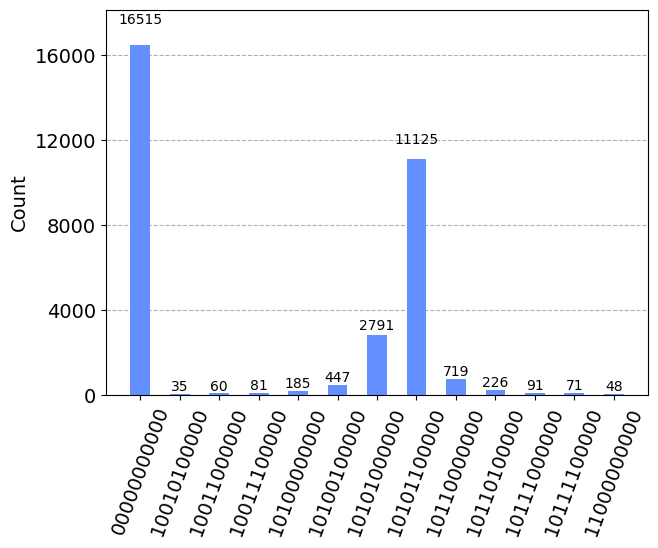

In [54]:
shots = (2**f_qcirc.num_qubits)*16

# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
t_qpe2 = transpile(f_qcirc, aer_sim)
results = aer_sim.run(t_qpe2, shots=shots).result()
answer = results.get_counts()

every_value_in_array_equals = lambda array,compare_val : len([0 for val in array if val == compare_val]) == len(array)

keys_to_keep = []
for key,val in answer.copy().items():
    if val < 30:
        answer.pop(key)
    if key in answer and every_value_in_array_equals(key[-3:], '0'):
        # keep this one since it must measure '000' for the first three
        keys_to_keep.append(key)
answer = {key:answer[key] for key in keys_to_keep}
plot_histogram(answer)

In [9]:
# it needs 2*logn + 1 qubits
# FABLE: Fast Approximate Quantum Circuits for Block-Encodings
fable_qcirc, alpha = fable(normalized_laplacian, epsilon=0.0)
print(fable_qcirc.num_clbits)
print(fable_qcirc.num_qubits)
fable_qcirc.draw()

0
5


»
q_0: ────────────────■───────────────────────────────────■─────────X────────»
                     │                                   │         │        »
q_1: ────────────────┼──────────────────────────────■────┼─────────┼────────»
       ┌───┐         │                              │    │         │        »
q_2: ──┤ H ├────■────┼─────────────────────────■────┼────┼─────────X────────»
       ├───┤    │    │                         │    │    │                  »
q_3: ──┤ H ├────┼────┼────────────────────■────┼────┼────┼──────────────────»
     ┌─┴───┴─┐┌─┴─┐┌─┴─┐┌──────────────┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌──────────────┐»
q_4: ┤ Ry(π) ├┤ X ├┤ X ├┤ Ry(-0.25268) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ Ry(-0.25268) ├»
     └───────┘└───┘└───┘└──────────────┘└───┘└───┘└───┘└───┘└──────────────┘»
«                       
«q_0: ──────────────────
«                       
«q_1: ───────■───X──────
«     ┌───┐  │   │      
«q_2: ┤ H ├──┼───┼──────
«     └───┘  │   │ ┌───┐
«q_3: ──■────┼───X─┤ H ├
«     ┌─┴─┐┌─┴─┐   └───┘
«q_4: ┤ X ├┤ X ├────────
«     └───┘└───┘

# Now time to implement the matrix into qiskit directly

In [149]:

def quantum_spectral_clustering_attempt(data, data_size, k_clusters):
    # initialize circuit
    n = ceil(log2(data_size))
    t = n + int(ceil(2 + log2(1/(2*e0))))
    user_selected_d = n
    
    # print(t+n+n)
    # must be t+n+n qubits
    num_bits = t+n+n
    qsc_circ = QuantumCircuit(num_bits,num_bits)

    # first step
    qsc_circ = unitary_initilization(qsc_circ,t,n)
    
    adjacency, weight_matrix = get_adjacency_and_weight_matrix(data, user_selected_d)

    normalized_laplacian = NormalizedLaplaceTransform(weight_matrix)/(2*user_selected_d) # just to get eigenvalues from [0,1], doesn't change eigenvectors

    print(f"normalized_laplacian:{normalized_laplacian}")

    # print(laplacian)
    from numpy.linalg import eig
    # print("verify laplacian has eigenvalues 0 <= lambda")
    
    print(f"eig(laplacian):{eig(normalized_laplacian)}")

    # second step

    return normalized_laplacian

N = len(X_blobs)
n = ceil(log2(N))
user_selected_d = n
# normalized_laplacian = compute_laplacian(X_blobs, N, k_clusters=2)

# get_approximated_exponential_unitary(np.array([[8,-7],[1,0]]), iterations=1000)
p = [[8,-7],[1,0]]


array([[False, False],
       [False, False]])

In [63]:
import math
math.exp(2+1j)

TypeError: can't convert complex to float

In [113]:
from sympy.matrices import Matrix
a = Matrix([[1,1],[-1,-2]])
b = Matrix([[1+1j,3+4j],[-1+1j,0+0j]])
print(a*b)
print(a*(3*b))
print(np.array(a*b)[0][0] == 2.0*1j)
c = a*(3*b)
print(c)
real_portion,imaginary_portion = c.as_real_imag()
print(f"real_portion:{real_portion}")
print(f"imaginary_portion:{imaginary_portion}")
e = 9.0+12.0*1j
print(imaginary_portion[0])
v = float(real_portion[1]) + float(imaginary_portion[1])*1j
print(np.array(imaginary_portion)[1][1])
v == e

Matrix([[2.0*I, 3.0 + 4.0*I], [1.0 - 3.0*I, -3.0 - 4.0*I]])
Matrix([[6.0*I, 9.0 + 12.0*I], [3.0 - 9.0*I, -9.0 - 12.0*I]])
False
Matrix([[6.0*I, 9.0 + 12.0*I], [3.0 - 9.0*I, -9.0 - 12.0*I]])
real_portion:Matrix([[0, 9.00000000000000], [3.00000000000000, -9.00000000000000]])
imaginary_portion:Matrix([[6.00000000000000, 12.0000000000000], [-9.00000000000000, -12.0000000000000]])
6.00000000000000
-12.0000000000000


True

In [143]:
temp = Matrix([0.1+5.4j,2.3+0.5j])
print(temp)
# r,i = temp.as_real_imag()
# print(r)
# print(i)
# print(len(r))
# x = np.zeros(shape=np.array(r).shape)
# y = np.zeros(shape=np.array(r).shape)
# for a in range(len(y)):
#     for b in range(len(y[a])):
#         x[a][b] = float(r[a+b])
#         y[a][b] = float(i[a+b])


# z = x + y*1j
# print(z)
# print(type(z))
# print(z)
# print('-----')
# print(z.real)
# print(z.imag)
# print((z.real + z.imag*1j) == z)


def convert_sympy_to_numpy_imaginary_matrix(m):
    r,i = m.as_real_imag() # seperate into real and imaginary parts
    x = np.zeros(shape=np.array(r).shape)
    y = np.zeros(shape=np.array(r).shape)
    for a in range(len(y)):
        for b in range(len(y[a])):
            x[a][b] = float(r[a+b])
            y[a][b] = float(i[a+b])
    return (x + y*1j).copy()

z = convert_sympy_to_numpy_imaginary_matrix(temp)
print(z.real)
print(z.imag)

Matrix([[0.1 + 5.4*I], [2.3 + 0.5*I]])
[[0.1]
 [2.3]]
[[5.4]
 [0.5]]


In [159]:
a = np.array([1,0])

zero_p = np.outer(a,np.transpose(a))

np.kron(np.eye(2), zero_p)

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])